# A/B Testing and T-Tests

Unit 1 / Lesson 4 / Assignment 6

### Evaluating A/B Tests Using T-Tests

A/B testing is the standard method for comparing two groups in data science, and t-tests are the standard for understanding the meaninfulness of that comparison.

To evaluate A/B testing with a t-tests, we need three pieces of information:
- Some summary of central tendancy for each group. typically the mean
- The amount of variability in each group. typically the standard deviation
- The size of each group (n)

We use the standard deviation and size of each group to give the means some context.
Noisier groups with more variability (higher standard deviations) must have a larger difference between the means for us to be confident it is a meaningful difference and not the result of noise.
On the other hand, larger groups give us more accurate means that can potentially reduce noise and let us detect more nuanced differences in the groups.

A __T-Test__ calculates the size of the difference between two means given the variance and sample size:
$$t = \frac{\bar{y_1}-\bar{y_2}}{\sqrt{s^2_1/N_1+s^2_2/N_2}}$$

$\bar{y_1}$ and $\bar{y_2}$ represent the sample means of groups 1 and 2.

$s_1$ and $s_2$ represent the sample standard deviations of groups 1 and 2.

$N_1$ and $N_2$ represent the sample sizes for groups 1 and 2.

The top of the formula is pretty easy- mean of group 1 minus the mean of group 2, that's the number we are interested in understanding.
In the bottom part of the formula we compute the sum of each group's squared standard deviation divided by sample size.
We then take the square root of that value.
Finally, we divide the top (difference in means) by the bottom (variability over sample size) to get the relative size of the difference in means given the amount of noise in the data.
his is called the t-value. Larger t-values mean that the difference between the groups is less likely to be due to noise.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

In [8]:
#Keeping the random data the same over multiple runs of the code.
np.random.seed(66)

#Storing our randomly generated data and labels.
data = []
groups = []
labels_var = []
labels_size = []

#The values we use for the standard deviations and the sample sizes.
variability = [5, 20, 50]
sizes = [10, 100, 10000]

#Generating data for each group for each combination of variability and sample size.
for var in variability:
    for size in sizes:
        data.extend(np.random.normal(20,var,size))
        data.extend(np.random.normal(35,var,size))
        labels_var.extend([var]*size*2)
        labels_size.extend([size]*size*2)
        groups.extend(['group1']*size)
        groups.extend(['group2']*size)


In [9]:
# make a dataframe
data = pd.DataFrame({'data': data, 
                     'groups' : groups,
                    'variability':labels_var,
                    'size':labels_size})
print(data.head())

        data  groups  variability  size
0  27.078072  group1            5    10
1  14.573568  group1            5    10
2  16.918460  group1            5    10
3  16.215419  group1            5    10
4  21.735239  group1            5    10


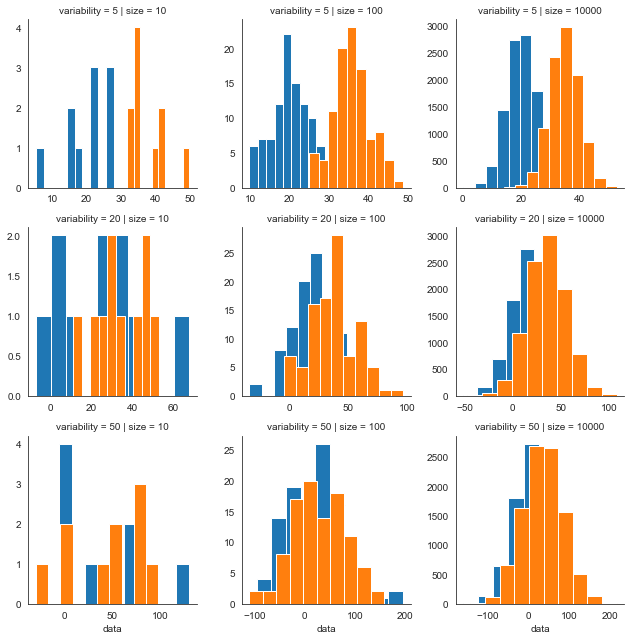

In [11]:
# Plotting the data.  
# Because we organized the data frame in a stacked (long) format, the plotting code is very straightforward.
sns.set_style('white')

g = sns.FacetGrid(data, col="size", row="variability", hue='groups', sharex=False, sharey=False)
g.map(plt.hist,'data')
plt.show()

### Analyzing Data
Notice how as the variability gets larger, it gets harder and harder to tell the means apart.
However it is clear that regarless of variability, the larger the sample size, the easier it is to tell the group means apart.
Even when the variance is at its highest (variance = 50), it is possible to discern two distinct peaks when the sample size is 10000.

Now let's calculate t-tests for each of these plots.
The t-test statistic provides a one-number summary of the information in the plot above.
Rather than squinting at two overlapping probability distributions and trying to intuit whether they are different, we can use hard numbers.

In [16]:
# Setting the three non-data columns to work as multi-indices. 
# This makes it much easier to get subsections of stacked data.
data_test = data.set_index(['groups', 'size', 'variability'])

# storing out t-values and p-values
tvals=[]
pvals=[]

# for each combination of sample sizes and variability, compare using a t-test
for size in sizes:
    for var in variability:
        a = data_test['data'].xs(('group1', size, var), level=('groups', 'size', 'variability'))
        b = data_test['data'].xs(('group2', size, var), level=('groups', 'size', 'variability'))
        tval, pval = stats.ttest_ind(b, a, equal_var=True)
        tvals.append(tval)
        pvals.append(pval)
        
print('t-value: {}\n'+
     'p-value: {}'.format(tval, pval))

t-value: {}
p-value: 21.26816177290222


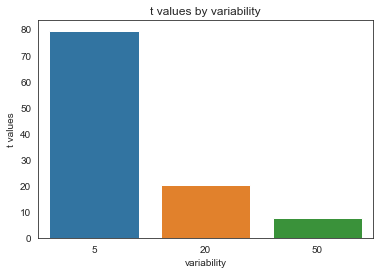

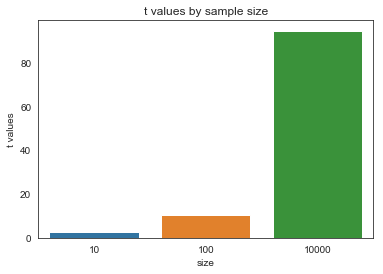

In [15]:
#Creating a data frame for plotting purposes.
tvals_plot = pd.DataFrame({'t' : tvals,
                          'p' : pvals,
                          'variability' : variability*3,
                          'size' : np.repeat(sizes, 3)})

# t-values by variability
ax = sns.barplot(y='t', x='variability', ci=None, data=tvals_plot)
ax.set(ylabel='t values', title='t values by variability')

plt.show()

# t-values by sample size
ax = sns.barplot(y='t', x='size', ci=None, data=tvals_plot)
ax.set(ylabel='t values', title='t values by sample size')

plt.show()

### T-tests and AB testing

__A/B Testing__ and __t-tests__ aren't worht much alone, but together you're ready to build something.
Without a __t-test__ (or some similar measure) we have no way of getting at the question we really care about: 'are the groups we're testing really different?'
With a __t-test__ we can see the size of the group difference divided by the noise level of the data.
Bigger t-values signal a group difference large enough to be interesting.

What is a 'bigger' t-value, though?
Another way to look at that questions is 'What is the probability of getting a t-value this extreme or more so if there were no difference between the groups in the population?'
We can decide how improbable we need our t-value to be before we accept that there is a real difference between the two groups.
he probability we refer to is called a __p-value__, and the threshold of improbability we choose is called a __significance level__.